In [2]:
'''import data using pandas library '''
import numpy as np
import pandas as pd

''' import data visualization libraries '''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle
''' open the data file and present first 5 rows '''
df = pd.read_csv('Z:\COMP 3710_01 - Applied Artificial Intelligence (Fall 19 Park)\Project AI Crime\crime-in-vancouver\crime.csv')
# print(df.head())

''' drop 'MINUTE' columns since it will not be used in data representation '''

df_drop = df.drop(['MINUTE'], axis = 1, inplace = True)
#print(df.head()) 

''' check for data completeness '''
#df.info()

'''
 'RangeIndex: 530652 entries, 0 to 530651'
 'HOUR 476290 non-null float64'
 'NEIGHBOURHOOD 474028 non-null object'
 'HUNDRED_BLOCK 530639 non-null object'
  tells us that the data is incomplete in these areas.

  Need to fill in data identifies as 'Not given'
'''
df['HOUR'].fillna(0000, inplace = True)
df['NEIGHBOURHOOD'].fillna('Not Given', inplace = True)
df['HUNDRED_BLOCK'].fillna('Not Given', inplace = True)
#df.info()

'''
 since data is allocated in separated columns,
 need to put all data in one column named 'FULL_DATE'
'''
df['FULL_DATE'] = pd.to_datetime({'year': df['YEAR'], 'month': df['MONTH'], 'day':df['DAY']})

''' 
use pandas.day_name() to determine the day of a crime / use .dayofweek for (Monday = 0, Tuesday = 1, etc.)
'''
df['DAY_OF_WEEK'] = df['FULL_DATE'].dt.day_name()
#print(df.head())

'''
using the date as indexes is helpfull
'''
df.index = pd.DatetimeIndex(df['FULL_DATE'])
print(df.index)

''' 
filtering the data excluding the last days of the last month
the data set was extracted
'''
df = df[df['FULL_DATE'] < '2017-07-01']
#print(df.tail())

''' categorising the types of crimes '''
# print('Categories of Crime and thier number of occurrences')
# print(df['TYPE'].value_counts().sort_index())

''' a function to sort out crime types on most occuring ones and others '''
def type(crime_type):
    if 'Theft' in crime_type:
        return 'Theft'
    elif 'Break' in crime_type:
        return 'Break and Enter'
    elif 'Homicide' in crime_type:
        return 'Homicide'
    elif 'Collision' in crime_type:
        return 'Vehicle Collision'
    else:
        return 'Other'

''' add a column named 'CATEGORY' to display the type of crime comminted '''
df['CATEGORY'] = df['TYPE'].apply(type)


'''
 associate 'Vehicle Collision' with an acident, not a crime 
 assign crimes to 'crime' var
 assign car collisions to 'car_coll' var
 '''
car_coll = df[df['CATEGORY'] == 'Vehicle Collision']
crime = df[df['CATEGORY'] != 'Vehicle Collision']


''' creating a time series graph with crimes per day '''
crime_per_day = pd.DataFrame(crime['FULL_DATE'] != '2011-06-11')
print(df.head(10))

DatetimeIndex(['2003-05-12', '2003-05-07', '2003-04-23', '2003-04-20',
               '2003-04-12', '2003-03-26', '2003-03-10', '2003-06-28',
               '2003-02-16', '2003-07-09',
               ...
               '2017-03-26', '2017-02-09', '2017-05-25', '2017-06-17',
               '2017-01-18', '2017-03-03', '2017-05-29', '2017-04-13',
               '2017-06-05', '2017-06-06'],
              dtype='datetime64[ns]', name='FULL_DATE', length=530652, freq=None)
                                         TYPE  YEAR  MONTH  DAY  HOUR  \
FULL_DATE                                                               
2003-05-12                        Other Theft  2003      5   12  16.0   
2003-05-07                        Other Theft  2003      5    7  15.0   
2003-04-23                        Other Theft  2003      4   23  16.0   
2003-04-20                        Other Theft  2003      4   20  11.0   
2003-04-12                        Other Theft  2003      4   12  17.0   
2003-03-26       

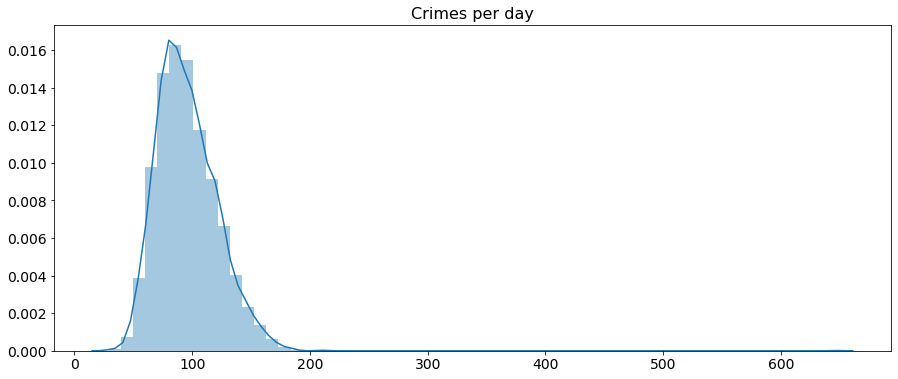

In [4]:
''' ploating crimes per day using 'resample('D')' to group it by day '''
plt.figure(figsize=(15, 6))
plt.title('Crimes per day', fontsize=16)
plt.tick_params(labelsize = 14)
sns.distplot(crime.resample('D').size(), bins=60)

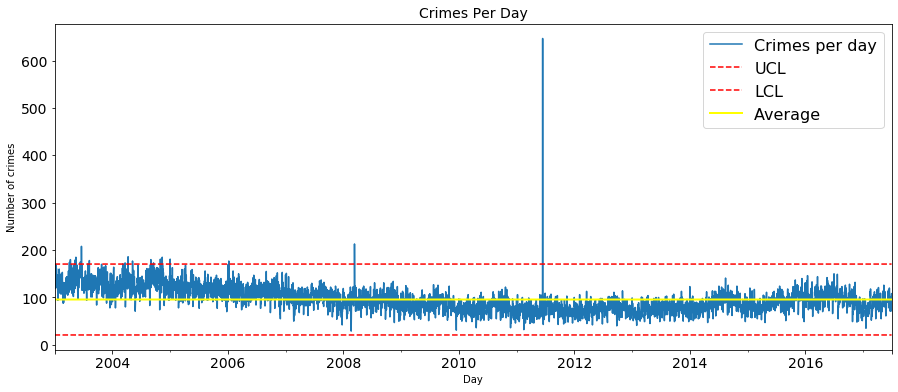

In [5]:
''' creating upper and lower control bounds for crimes per day without the outlier on the date '2011-06-15' '''

crimes_per_day = pd.DataFrame(crime[crime['FULL_DATE'] != '2011-06-15'].resample('D').size())
crimes_per_day['MEAN'] = crime[crime['FULL_DATE'] != '2011-06-15'].resample('D').size().mean()
crimes_per_day['STD'] = crime[crime['FULL_DATE'] != '2011-06-15'].resample('D').size().std()
UL = crimes_per_day['MEAN'] + 3 * crimes_per_day['STD']
LL = crimes_per_day['MEAN'] - 3 * crimes_per_day['STD']

plt.figure(figsize=(15,6))
crime.resample('D').size().plot(label='Crimes per day')
UL.plot(color='red', ls='--', linewidth=1.5, label='UCL')
LL.plot(color='red', ls='--', linewidth=1.5, label='LCL')
crimes_per_day['MEAN'].plot(color='yellow', linewidth=2, label='Average')
plt.title('Crimes Per Day', fontsize=14)
plt.xlabel('Day')
plt.ylabel('Number of crimes')
plt.tick_params(labelsize = 14)
plt.legend(prop={'size':16})

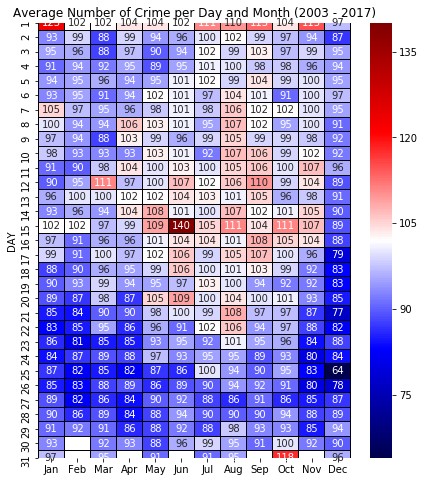

In [3]:
''' creating pivot table with day and month '''
crime_pivot_tab = crime[(crime['FULL_DATE'] != '2011-06-05')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=len)

''' creating a pivot table with num of years each day had '''
crime_pivot_tab_year_count = crime[(crime['FULL_DATE'] != '2011-06-05')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=lambda x: len(x.unique()))

''' creating a pivot table with average values '''
crime_avg = crime_pivot_tab / crime_pivot_tab_year_count
crime_avg.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

''' using seaborn heatmap for color representation '''
plt.figure(figsize=(7, 8))
plt.title('Average Number of Crime per Day and Month (2003 - 2017)', fontsize=12)
sns.heatmap(crime_avg.round(), cmap='seismic', linecolor='black', linewidth=0.1, cbar=True, annot=True, fmt=".0f")

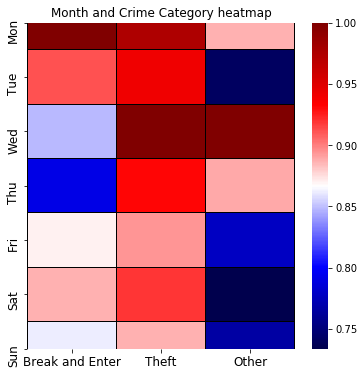

In [4]:
''' make a heatmap showing the day of the week and type of crime '''
crime_pivot_tab = crime.pivot_table(values='TYPE', index='CATEGORY', columns='DAY_OF_WEEK', aggfunc=len)

''' to compare categories -> divide each by the max val '''
crime_scaled = pd.DataFrame(crime_pivot_tab.iloc[0] / crime_pivot_tab.iloc[0].max())

for i in [3, 2]:
    crime_scaled[crime_pivot_tab.index[i]] = pd.DataFrame(crime_pivot_tab.iloc[i] / crime_pivot_tab.iloc[i].max())

crime_scaled.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

plt.figure(figsize = (6, 6))
plt.title('Day and Crime Category heatmap', fontsize=12)
plt.tick_params(labelsize = 12)
sns.heatmap(crime_scaled, cmap='seismic', linecolor='black', linewidth=0.1, cbar=True)

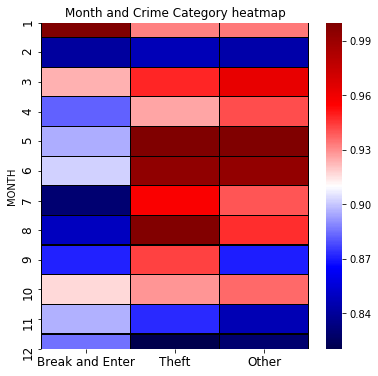

In [5]:
''' create a pivot table with months and categories of criems '''
crime_pivot_tab = crime.pivot_table(values='TYPE', index='CATEGORY', columns='MONTH', aggfunc=len)

''' to compare categories -> divide each by the max val '''
crime_scaled = pd.DataFrame(crime_pivot_tab.iloc[0] / crime_pivot_tab.iloc[0].max())

''' scale others '''
for i in [3,2]:
    crime_scaled[crime_pivot_tab.index[i]] = pd.DataFrame(crime_pivot_tab.iloc[i] / crime_pivot_tab.iloc[i].max())

plt.figure(figsize = (6, 6))
plt.title('Month and Crime Category heatmap', fontsize=12)
plt.tick_params(labelsize = 12)
sns.heatmap(crime_scaled, cmap='seismic', linecolor='black', linewidth=0.1, cbar=True)

In [12]:
''' Data Preprocessing '''
new_crime = df.drop(['CATEGORY', 'DAY_OF_WEEK', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'X', 'Y'], axis=1)

le = preprocessing.LabelEncoder()
new_crime['TYPE'] = le.fit_transform(new_crime['TYPE'])
new_crime['HUNDRED_BLOCK'] = le.fit_transform(new_crime['HUNDRED_BLOCK'])
new_crime['NEIGHBOURHOOD'] = le.fit_transform(new_crime['NEIGHBOURHOOD'])
new_crime['Latitude'] = le.fit_transform(new_crime['Latitude'])
new_crime['Longitude'] = le.fit_transform(new_crime['Longitude'])
new_crime['FULL_DATE'] = le.fit_transform(new_crime['FULL_DATE'])


''' Preparing data and target vars '''
cols = [col for col in new_crime.columns if col not in ['TYPE']]
data = new_crime[cols]
target = new_crime['TYPE']

''' Splitting the data into training and testing sets '''
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.33, random_state = 42)


eps = 5e-3
alphas_lasso, coefs_lasso, _ = lasso_path(data, target, eps, fit_intercept=False)

plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

NameError: name 'alphas_enet' is not defined

In [13]:
alphas_enet, coefs_enet, _ = enet_path(data, target, eps=eps, l1_ratio=0.8, fit_intercept=False)
plt.figure(3)
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

NameError: name 'alphas_positive_enet' is not defined